In [2]:
PRFX_ESMB = 'MelEsmb0729A1'

In [6]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
import matplotlib.pyplot as plt

class Param: pass

p_esmb = f'../output/{PRFX_ESMB}'; Path(p_esmb).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

In [7]:
prfx2wgt = {
    'Mel0726B2': 1,
    'Mel0728A1': 1,
    'Mel0726C1': 1,
    'Mel0726D1': 1,
    'Mel0726E1': 1,    
    'Mel0727A1': 1,
    'Mel0727B1': 1,
    'Mel0726G2': 1,
    'Mel0726H2': 1,
    'Mel0728C1': 1,
}

In [8]:
prfx2oofs = {}
for prfx in prfx2wgt.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof[:,-param.LASTM:].mean(1)
        oofs += list(oof)
    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)
    
    oofs = np.array(oofs)
    prfx2oofs[prfx] = oofs

    scr = roc_auc(ys, oofs)
    print(prfx, param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}')

Mel0726B2 efficientnet-b0 224 0.9210 0.8914
Mel0728A1 efficientnet-b1 224 0.9199 0.8970
Mel0726C1 efficientnet-b1 224 0.9177 0.8877
Mel0726D1 efficientnet-b2 224 0.9175 0.8995
Mel0726E1 efficientnet-b3 224 0.9167 0.8977
Mel0727A1 efficientnet-b3 224 0.9208 0.8973
Mel0727B1 efficientnet-b4 224 0.9221 0.8960
Mel0726G2 efficientnet-b5 224 0.9182 0.8999
Mel0726H2 efficientnet-b6 224 0.9212 0.9046
Mel0728C1 efficientnet-b0 384 0.9253 0.8985


In [9]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += wgt*prfx2oofs[prfx]
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(prfx, f'{scr:.4f}', f'{scr20:.4f}')

Mel0728C1 0.9357 0.9191


Mel0726B2 0.19685945771553873


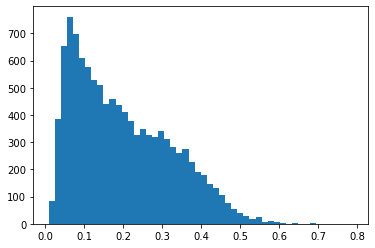

Mel0728A1 0.14374109390530843


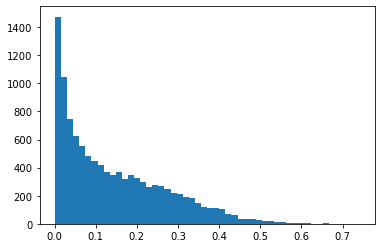

Mel0726C1 0.15498520338773913


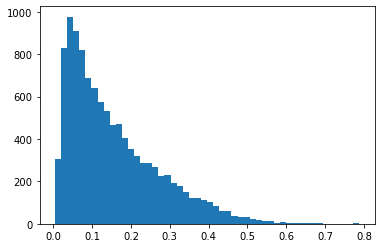

Mel0726D1 0.18698534794493166


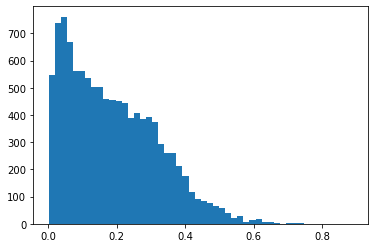

Mel0726E1 0.1666454077276706


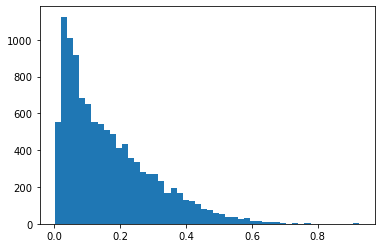

Mel0727A1 0.19832532903536787


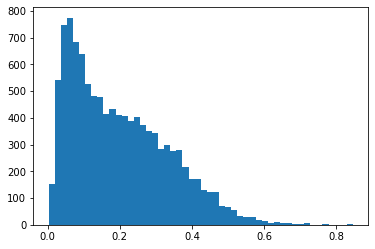

Mel0727B1 0.2204789255177449


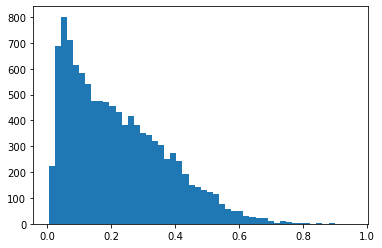

Mel0726G2 0.1624768642377327


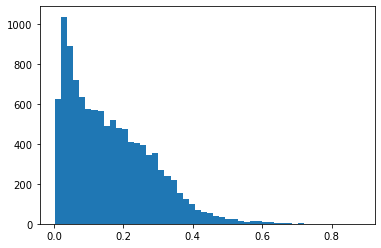

Mel0726H2 0.17742668111296572


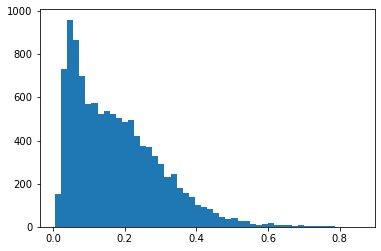

Mel0728C1 0.1841396226439584


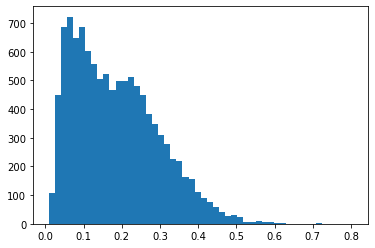

In [10]:
dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv') 


wgt_ttl=0
sub_esmb=np.zeros(len(dfsub))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    dfsubi = pd.read_csv(f'{p_out}/submission_{prfx}_avglast{param.LASTM}.csv')
    wgt_ttl+=wgt
    subi = dfsubi.target
    print(prfx, subi.mean())
    plt.hist(subi, bins=50);
    plt.show()
    sub_esmb+=subi
sub_esmb/=wgt_ttl

0.17920639332289579


,image_name,target
0,ISIC_0052060,0.083824
1,ISIC_0052349,0.040790
2,ISIC_0058510,0.083378


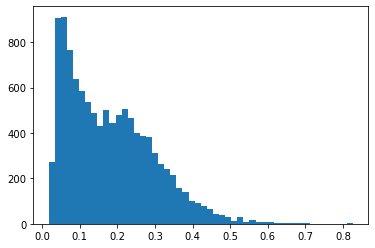

In [11]:
print(sub_esmb.mean())
dfsub.target = sub_esmb

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [12]:
dfsub.to_csv(f'{p_esmb}/submission_{PRFX_ESMB}.csv', index=False)